In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

/Users/max/Documents/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


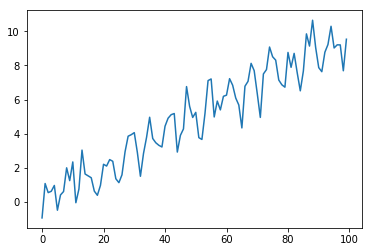

In [2]:
x = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
#x = np.arange(10)+5, "AA"
plt.plot(x)
plt.show()

In [3]:
def prepare_ts_forecast(x, name):
    """
    This method prepares a singular time series for a forecasting task
    """
    n = len(x)
    return pd.DataFrame({"id" : ["A"]*n, "time": range(n) , "val": x, "kind": name})

In [4]:
df = prepare_ts_forecast(x, "AA")
df.head()

,id,kind,time,val
0,A,AA,0,-0.957407
1,A,AA,1,1.063545
2,A,AA,2,0.529864
3,A,AA,3,0.607998
4,A,AA,4,0.950408


In [5]:
df_shift = roll_time_series(df, 
                            column_id="id", 
                            column_sort="time", 
                            column_kind="kind",
                            rolling_direction=1, maximum_number_of_timeshifts=10)
print(df.shape); print(df_shift.shape)

(100, 4)
(945, 4)


In [6]:
df_shift.head()

,time,val,id,kind
846,0.0,-0.957407,1,AA
0,0.0,-0.957407,10,AA
91,1.0,1.063545,10,AA
183,2.0,0.529864,10,AA
276,3.0,0.607998,10,AA


In [7]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="val", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 99/99 [00:01<00:00, 60.99it/s]
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue

In [8]:
print(X.shape)
X.head()

(99, 465)


variable,feature__abs_energy,feature__absolute_sum_of_changes,"feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""",...,feature__time_reversal_asymmetry_statistic__lag_1,feature__time_reversal_asymmetry_statistic__lag_2,feature__time_reversal_asymmetry_statistic__lag_3,feature__value_count__value_-inf,feature__value_count__value_0,feature__value_count__value_1,feature__value_count__value_inf,feature__value_count__value_nan,feature__variance,feature__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1.0,0.916629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2.0,2.047758,2.020953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.205364,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.021063,1.0
3.0,2.328514,2.554634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.243674,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.731227,0.0
4.0,2.698175,2.632768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.724934,-1.328793,0.0,0.0,0.0,0.0,0.0,0.0,0.577823,0.0
5.0,3.601451,2.975178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.380651,-1.350492,0.0,0.0,0.0,0.0,0.0,0.0,0.527673,0.0


In [11]:
X

variable,feature__abs_energy,feature__absolute_sum_of_changes,"feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""",...,feature__time_reversal_asymmetry_statistic__lag_1,feature__time_reversal_asymmetry_statistic__lag_2,feature__time_reversal_asymmetry_statistic__lag_3,feature__value_count__value_-inf,feature__value_count__value_0,feature__value_count__value_1,feature__value_count__value_inf,feature__value_count__value_nan,feature__variance,feature__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1.0,0.916629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2.0,2.047758,2.020953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.205364,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.021063,1.0
3.0,2.328514,2.554634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.243674,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.731227,0.0
4.0,2.698175,2.632768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.724934,-1.328793,0.000000,0.0,0.0,0.0,0.0,0.0,0.577823,0.0
5.0,3.601451,2.975178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.380651,-1.350492,0.000000,0.0,0.0,0.0,0.0,0.0,0.527673,0.0
6.0,3.856399,4.430511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.334568,-0.883533,-0.729778,0.0,0.0,0.0,0.0,0.0,0.563446,0.0
7.0,4.009895,5.327221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.147261,-0.650856,-0.704267,0.0,0.0,0.0,0.0,0.0,0.484441,0.0
8.0,4.361991,5.528811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.168995,-0.387961,-0.702416,0.0,0.0,0.0,0.0,0.0,0.433472,0.0
9.0,8.307791,6.921839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062979,0.368877,0.275889,0.0,0.0,0.0,0.0,0.0,0.654873,0.0


In [15]:
y = df.val

In [19]:
ada = AdaBoostRegressor()
ada.fit(X, y[1:])
y_pred = ada.predict(X)

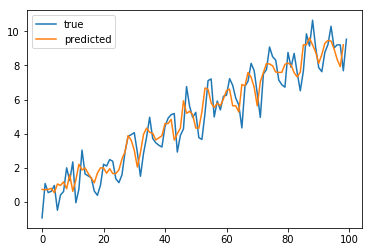

In [21]:
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()